In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False


In [2]:
lam = 0.15 #lambda
mu = 0.375 #mu
rho = 0.1 #discount factor lam+2*mu+rho=1
cost = 1.4 #technological cost
a = 1.0 #fault probability
p1 = 0.9
p2 = 0.1
epilson = 0.001 #converge threshold
maxLength = 32

In [3]:


theta = np.zeros([maxLength+1, maxLength+1])
for x in range (maxLength+1):
    for y in range(maxLength+1):
        if x!=y:
            if a*lam*(p1*x+p2*y-min(x,y))!=0:
                test=1-((mu*(x+y)-lam*min(x,y))/(a*lam*(p1*x+p2*y-min(x,y))))
                theta[x][y] = max(0, test)
    
#for cost in cost_array:
print(cost)
value = np.zeros([maxLength+1, maxLength+1])
policy = np.zeros([maxLength+1, maxLength+1])
while True:
    while True:
        delta = 0
        val = value.copy()
        for x in range(maxLength+1):
            for y in range(maxLength+1):
                v = value[x][y]
                b = policy[x][y]
                xx = min(x+1,maxLength)
                yy = min(y+1,maxLength)
                if xx == x or yy == y:
                    value[x][y] = x+y+cost*b+mu*(val[max(x-1,0)][y]+val[x][max(y-1,0)])+(1-(1-b)*a)*lam*max(val[xx][y],val[x][yy])+p1*(1-b)*a*lam*val[xx][y]+p2*(1-b)*a*lam*val[x][yy]
                else:
                    value[x][y] = x+y+cost*b+mu*(val[max(x-1,0)][y]+val[x][max(y-1,0)])+(1-(1-b)*a)*lam*min(val[xx][y],val[x][yy])+p1*(1-b)*a*lam*val[xx][y]+p2*(1-b)*a*lam*val[x][yy]
                delta = max(delta, abs(v-value[x][y]))
        if delta<epilson:
            break
    stable = True
    for x in range(maxLength+1):
        for y in range(maxLength+1):
            old = policy[x][y]
            xx = min(x+1,maxLength)
            yy = min(y+1,maxLength)
            diff = a*lam*(p1*value[xx][y]+p2*value[x][yy]-min(value[xx][y],value[x][yy]))
            if diff <= cost:
                policy[x][y] = 0
            else:
                policy[x][y] = 1
            if old != policy[x][y]:
                stable = False
    if stable:
        if np.count_nonzero(policy) == 0:  #policy is all zeros
            print('tipping point is ', cost)
        print('policy = ', policy)
        break

1.4
tipping point is  1.4
policy =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


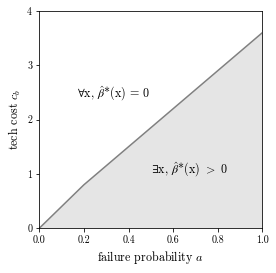

In [10]:
# By changing different parameters, we get the tipping points
r = [0,0.2,0.4,0.6,0.8,1]
c1 = [0,0.8,1.5,2.2,2.9,3.6]
c2 = [0,0.6,1.1,1.7,2.2,2.7]
c3 = [0,0.3,0.6,0.9,1.1,1.4]
y = [0,0,0,0,0,0]
plt.figure(figsize=(4,4))
# l1=plt.plot(r,c1,'r--')
# l2=plt.plot(r,c2,'y--',label='λ=1, μ=1')
# l3=plt.plot(r,c3,'g--',label='λ=0.4, μ=1')
plt.plot(r,c1,'grey')
plt.fill_between(r,0,c1,facecolor = 'grey',alpha=0.2)
plt.yticks([y for y in range(5) if y % 1 == 0])
plt.xlabel('failure probability $a$',size=12)
plt.ylabel('tech cost $c_b$',size=12)
plt.text(0.17, 2.4, "$∀$x, $\hat{β}$*(x) = 0", size=12)
plt.text(0.5, 1.0, "$∃$x, $\hat{β}$*(x) $>$ 0",size=12)
axes = plt.gca()
axes.set_xlim([0,1.0])
axes.set_ylim([0,4.0])
# plt.show()
plt.savefig("Fig6-1.pdf")

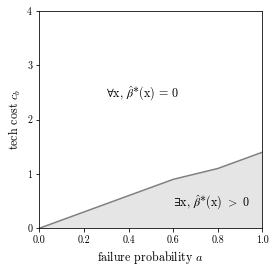

In [9]:
# By changing different parameters, we get the tipping points
r = [0,0.2,0.4,0.6,0.8,1]
c1 = [0,0.8,1.5,2.2,2.9,3.6]
c2 = [0,0.6,1.1,1.7,2.2,2.7]
c3 = [0,0.3,0.6,0.9,1.1,1.4]
plt.figure(figsize=(4,4))
# l1=plt.plot(r,c1,'r--',label='λ=1.6, μ=1')
# l2=plt.plot(r,c2,'y--',label='λ=1, μ=1')
# l3=plt.plot(r,c3,'g--')
plt.plot(r,c3,'grey')
plt.fill_between(r,0,c3,facecolor = 'grey',alpha=0.2)
plt.yticks([y for y in range(9) if y % 1 == 0])
plt.xlabel('failure probability $a$',size=12)
plt.ylabel('tech cost $c_b$',size=12)
plt.text(0.3, 2.4, "$∀$x, $\hat{β}$*(x) = 0", size=12)
plt.text(0.6, 0.4, "$∃$x, $\hat{β}$*(x) $>$ 0", size=12)
axes = plt.gca()
axes.set_xlim([0,1.0])
axes.set_ylim([0,4.0])
# plt.show()
plt.savefig("Fig6-2.pdf")